In [53]:
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tabulate import tabulate
import os 
import time
from matplotlib import colors as mcolors
from texttable import Texttable
import latextable

# Neoantingen Cancer Vaccine Model 

In [54]:
"Dynamical system of Neoantingen Vaccine for patients with melanoma "
"based on Marisabel et al (2021)"
def patientID_1(patient,tau,peptides,adjuvant):
    'Defining parameters of the model'
    "First step is to define the set of parameter and initial conditions per patient"
    patientv = patient
    "Vaccine parameters"
    dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    vac_time = 0.001 #Injection rate (20 secs per injection)
    rho = 1/vac_time
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1e-14 #L

    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patientv-1]
    m = alleles_k[patientv-1]
    l = 4*(n+m) + 4

    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473, 2167420.113, 1173316.913]),
                np.array([1484974.623,  2535151.868,    2284627.402]),
                np.array([2383016.796,  1526723.96, 1748749.88]),
                np.array([2022589.187,  3180789.851, 2759602.837,   2305265.682]),
                np.array([1663174.667,  1588701.641, 1749390.592,   1653025.941]),
                np.array([1927952.932,  1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patientv-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792,  271328.1446, 35471.5965,    33529.37879]),
                np.array([83978.51167,  31694.08875, 39710.93314]),
                np.array([23154.4359,   72622.70269,    4375.04084, 16491.62389]),
                np.array([19125.68472,  93663.04964,    53339.98855,    12503.98159]),
                np.array([96054.14771,  5452.233863,    8418.335798]),
                np.array([156840.5771,  96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patientv-1]/1 #1/day

    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"

    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day

    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*(1e-5)] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day

    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    lambda_all = np.array([0.978, 0.991, 1, 0, 0.8568, 1.141*(1e-4)])
    lambdaa = lambda_all[patient-1]
    s = 0.0839  

    "Initial Conditions"
    p0 = 0#h_p  # h_p 
    A_d0 = 0#500 # 0.5 * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0

    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j

    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k

    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          855265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3

    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1]]))#, A_CD40[patient-1]+A_CD80[patient-1]]))


    "Cancer vaccine model: System of ODEs"
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  

        n = alleles_j[patientv-1] # for alleles in MHC-I
        m = alleles_k[patientv-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point

        #some functions for later

        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A * (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float))*1e-12)

        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)

        "Vaccine peptide and adjuvant concentrations" 
        dotz[0] =  (rho)*h_p(t) - alpha_p*z[0]
        dotz[1] =  (rho)*h_a(t) - alpha_d*z[1]
        
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]

        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])

        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1

            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E)
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = k_ext*z[j1] - k_offj[i]*z[j2]
            dotz[j3] = k_offj[i]*z[j2] - k_in* z[j3]

        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1

            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E)
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = k_ext*z[k1] - k_offk[i]*z[k2]
            dotz[k3] = k_offk[i]*z[k2] - k_in* z[k3]

        #l = 4*(n+m) + 4 # number of equations up to this point

        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
   
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]


        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])

        return dotz
    
    'Start a clock'
    start = time.time()
    
    'timespan and ode-solver for each subinterval'
    t_f = 200
    steps = 100
    #tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters

    tau_vac=[]
    new_peptides = []
    new_adjuvant = []
    for i in range(len(tau)):
        tau_vac.append(tau[i])
        tau_vac.append(tau[i]+vac_time)
        
        new_peptides.append(peptides[i])
        new_peptides.append(0)
        
        new_adjuvant.append(adjuvant[i])
        new_adjuvant.append(0)
        
    tau_vac.append(t_f)
    tau = tau_vac
    t_all=[]
    for i in range(len(tau)-1):
        t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
    #eqs = 5 + 4*(n+m) + 5 # eqs in the system

    for i in range(len(tau)-1):
        t = t_all[i]
        N = len(t)     
        
        if (tau[i+1]-tau[i]<1):
            h_p = (new_peptides[i])*np.ones(N) 
            h_a = (new_adjuvant[i])*np.ones(N)
            
        if (tau[i+1]-tau[i]>=1):
            h_p = (new_peptides[i])*np.ones(N) 
            h_a = (new_adjuvant[i])*np.ones(N)
            
        h_p = interp1d(t, h_p,fill_value='extrapolate')    
        h_a = interp1d(t, h_a,fill_value='extrapolate')
        
        method = 'Radau' #'Radau' #<- solver for stiff system
        'Solve ODE system forward in time '
        z = solve_ivp(states,[tau[i], tau[i+1]],z0,method = method,dense_output=True)
        #print('Period ['+str(tau[i])+','+str(tau[i+1])+']') 
        
        'Getting state solution in vector form'
        z = z.sol(t)
        'Saving the solution for each subinterval'
        if i == 0:
            state = z
            dose_hp = h_p(t)
            dose_ha = h_a(t)

        if i>0:
            state = np.append(state, z,axis=1)
            dose_hp = np.append(dose_hp,h_p(t))
            dose_ha = np.append(dose_ha,h_a(t))

        z0 = np.transpose(z)[N-1]

    for i in range(len(t_all)):
        if i == 0:
            t = t_all[i]
        if i > 0: 
            t = np.append(t,t_all[i])
    
      
    'End the clock'
    end = time.time()
    rtime = end - start
    #print('The problem was solved in approx. ' + str(round(rtime,3)) +' seconds')
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
    
    return [t,state,dose_hp,dose_ha,rtime]

# Dose Optimization Problem of Cancer Neoantigen Vaccine

In [55]:
def Patient_info_1(patient,h_p_low,h_p_up,h_a_low,h_a_up,J):
    'Defining parameters of the model'
    "First step is to define the set of parameter and initial conditions per patient"

    "Vaccine parameters"
    dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    vac_time = 0.001 #Injection rate (20 secs per injection)
    rho = 1/vac_time
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1e-14 #L

    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patient-1]
    m = alleles_k[patient-1]
    l = 4*(n+m) + 4

    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473, 2167420.113, 1173316.913]),
                np.array([1484974.623,  2535151.868,    2284627.402]),
                np.array([2383016.796,  1526723.96, 1748749.88]),
                np.array([2022589.187,  3180789.851, 2759602.837,   2305265.682]),
                np.array([1663174.667,  1588701.641, 1749390.592,   1653025.941]),
                np.array([1927952.932,  1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patient-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792,  271328.1446, 35471.5965,    33529.37879]),
                np.array([83978.51167,  31694.08875, 39710.93314]),
                np.array([23154.4359,   72622.70269,    4375.04084, 16491.62389]),
                np.array([19125.68472,  93663.04964,    53339.98855,    12503.98159]),
                np.array([96054.14771,  5452.233863,    8418.335798]),
                np.array([156840.5771,  96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patient-1]/1 #1/day

    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"

    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day

    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*(1e-5)] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day

    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    lambda_all = np.array([0.978, 0.991, 1, 0, 0.8568, 1.141*(1e-4)])
    lambdaa = lambda_all[patient-1]
    s = 0.0839  

    "Initial Conditions"
    p0 = 0#h_p  # h_p 
    A_d0 = 0#500 # 0.5 * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0

    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j

    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k

    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          855265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3

    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1]]))#, A_CD40[patient-1]+A_CD80[patient-1]]))

    
    "The State System "
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  

        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point

        #some activation functions for later

        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A * (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float))*1e-12)

        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)

        "Vaccine peptide and adjuvant concentrations" 

        dotz[0] =  (rho)*h_p(t) - alpha_p*z[0]
        dotz[1] =  (rho)*h_a(t) - alpha_d*z[1]
    
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]

        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])

        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1

            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E)
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = k_ext*z[j1] - k_offj[i]*z[j2]
            dotz[j3] = k_offj[i]*z[j2] - k_in* z[j3]

        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1

            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E)
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = k_ext*z[k1] - k_offk[i]*z[k2]
            dotz[k3] = k_offk[i]*z[k2] - k_in* z[k3]


        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
     
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]

        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])

        return dotz
    
    "The Adjoint System"
    def adjoints(t,lamb):
        dotlamb = np.zeros(len(lamb))  #use np.zeros_like(z) for odeint  

        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point

        #some functions for later

        pM_I = N_A*(np.sum(np.fromiter((z.sol(t)[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A*(np.sum(np.fromiter((z.sol(t)[4*n + 7 + i*4] for i in range(m)),float))*1e-12)

        Psi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)

        'Derivatives of Psi, Phi and pMn with respect to DM, NCDi, ACDi'
        dPsi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                    * (pM_II)/(pM_II+K_pM))
        dPsi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                    * (pM_I)/(pM_I+K_pM))
        dPhi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                     * (pM_II- K_pM)/(pM_II+K_pM))
        dPhi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                     * (pM_I- K_pM)/(pM_I+K_pM))

        dPsi_4dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_4dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_8dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPsi_8dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))

        dPsi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)

        dPsi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)

        dDdT = -d*(((lambdaa*s*z.sol(t)[l+5])/(z.sol(t)[l+1]**2)*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                  /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))
        dDdACD8 = d*(((lambdaa*s)/(z.sol(t)[l+1])*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                  /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))

        "Vaccine peptide and adjuvant concentrations" 
        dotlamb[0] =  -(- alpha_p*lamb[0] + alpha_Ep*V_E/V_sc * lamb[4])
        dotlamb[1] =  -(- alpha_d*lamb[1]
                        - (r_D*K_a*z.sol(t)[2])/((K_a+z.sol(t)[1])**2)*(lamb[2] - lamb[3]))


        "Antigen-presenting cells: Dendritic cells "
        dotlamb[2] = -(Lambda*(1 - 2*z.sol(t)[2]/K_DC)*lamb[2] 
                      - (r_D*K_a)/(K_a+z.sol(t)[1]) * (lamb[2] - lamb[3]))
        dotlamb[3] = -(- delta_M*lamb[3] 
                      - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dDM) *(lamb[l+2]-lamb[l+4])
                      - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dDM) *(lamb[l+3]-lamb[l+5])
                      + rho_4*dPhi_4dDM *z.sol(t)[l+4] *lamb[l+4]
                      + rho_8*dPhi_8dDM *z.sol(t)[l+5] *lamb[l+5])


        "Antigen processing and presentation by mature DCs"
        dotlamb[4] = -(- ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4] for i in range(n)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4]*(lamb[5+i*4]-lamb[6+i*4]) 
                                                         for i in range(n)), float))) 
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4] for i in range(m)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4]*(lamb[4*n+5+i*4]-lamb[4*n+6+i*4])
                                                         for i in range(m)), float)))
                      - beta_p*lamb[4])

        for i in range(n):
            j = 5+i*4 #M_s^E
            j1 = j+1  #pM_s^E
            j2 = j1+1 #pM_s
            j3 = j2+1 #M_s

            dotlamb[j] = -(- k_onj *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[j]-lamb[j1]) 
                          - beta_M * lamb[j])
            dotlamb[j1] = -( k_offj[i]*(lamb[4]+lamb[j]-lamb[j1]) 
                           - k_ext * (lamb[j1] - lamb[j2] ) - beta_pM*lamb[j1] )
            dotlamb[j2] = -(k_offj[i]*(lamb[j3] - lamb[j2]) 
                           - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMj)*(lamb[l+2]-lamb[l+4])
                           - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMj) *(lamb[l+3]-lamb[l+5])
                           + rho_4*dPhi_4dpMj *z.sol(t)[l+4] *lamb[l+4]
                           + rho_8*dPhi_8dpMj *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[j3] =  -(k_in* (lamb[j]-lamb[j3]))

        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1

            dotlamb[k]  = -(- k_onk *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[k]-lamb[k1]) 
                           - beta_M * lamb[j])
            dotlamb[k1] = -( k_offk[i]*(lamb[4]+lamb[k]-lamb[k1]) 
                           - k_ext * (lamb[k1] - lamb[k2] ) - beta_pM*lamb[k1] )
            dotlamb[k2] = -(k_offk[i]*(lamb[k3] - lamb[k2]) 
                           - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMk)*(lamb[l+2]-lamb[l+4])
                           - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMk) *(lamb[l+3]-lamb[l+5])
                           + rho_4*dPhi_4dpMk *z.sol(t)[l+4] *lamb[l+4]
                           + rho_8*dPhi_8dpMk *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[k3] = -(k_in* (lamb[k]-lamb[k3]))

        #l = 4*(n+m) + 4 # number of equations up to this point

        "Tumor Cells"
        D = d*((z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)/(s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)


        dotlamb[l+1] = -(A + (r - 2*r*z.sol(t)[l+1]/K_T - D - z.sol(t)[l+1]*dDdT)*lamb[l+1] 
                        +(c_4*a_1/(a_1+z.sol(t)[l+1])**2*z.sol(t)[l+4])*lamb[l+4] 
                        +(c*(2*a*D**2*z.sol(t)[l+1])/((a+D**2 * z.sol(t)[l+1]**2)**2)*dDdT*z.sol(t)[l+5]
                          + c_8*z.sol(t)[l+4])*lamb[l+5])

        "Helper and Cytotoxic T cells"

        dotlamb[l+2] = -(b_4*(1-2*z.sol(t)[l+2]/(0.7*K_TC))*lamb[l+2] 
                     - sigma_4*F_p4*(Psi_4 + z.sol(t)[l+2]*dPsi_4dNCD4)*(lamb[l+2]-lamb[l+4])
                     + rho_4*dPhi_4dNCD4 *z.sol(t)[l+4]*lamb[l+4] - mu*lamb[l+2])
        dotlamb[l+3] = -( b_8*(1-2*z.sol(t)[l+3]/(0.3*K_TC))*lamb[l+3] 
                     - sigma_8*F_p8*(Psi_8 + z.sol(t)[l+3]*dPsi_8dNCD8)*(lamb[l+3]-lamb[l+5])
                     + rho_8*dPhi_8dNCD8 *z.sol(t)[l+5]*lamb[l+5] - mu*lamb[l+3])
        dotlamb[l+4] = -(A_4- sigma_4*F_p4*z.sol(t)[l+2]*dPsi_4dACD4*(lamb[l+2]-lamb[l+4]) 
                        + rho_4*(Phi_4 + z.sol(t)[l+4]*dPhi_4dACD4)*lamb[l+4]
                        + (c_4*(z.sol(t)[l+1]/(a_1+z.sol(t)[l+1])) - mu_4)*lamb[l+4] 
                        + c_8*z.sol(t)[l+1]*lamb[l+5])
        dotlamb[l+5] = -(A_8-(z.sol(t)[l+1]*dDdACD8)*lamb[l+1] 
                        -(sigma_8*F_p8*z.sol(t)[l+3]*dPsi_8dACD8*(lamb[l+3]-lamb[l+5]))
                        +(c*(D**2*z.sol(t)[l+1]**2)/(a+D**2*z.sol(t)[l+1]**2)
                          + c*z.sol(t)[l+5]*2*a*D*z.sol(t)[l+1]**2/((a+D**2*z.sol(t)[l+1]**2)**2)*dDdACD8)*lamb[l+5]
                        + (rho_8*Phi_8 + rho_8*dPhi_8dACD8*z.sol(t)[l+5]-mu_8)*lamb[l+5])

        return dotlamb 
    
    'Start a clock'
    start = time.time()
    
    'Forward-Backward Sweep Method for each subinterval'
    'timespan and ode-solver'
    t_f = 200
    steps = 100
    tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters

    tau_vac=[]
    for i in range(len(tau)):
        tau_vac.append(tau[i])
        tau_vac.append(tau[i]+vac_time)
    tau_vac.append(t_f)
    tau = tau_vac
    # tau.append(t_f)
    t_all=[]
    for i in range(len(tau)-1):
        t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
    eqs = 5 + 4*(n+m) + 5 # eqs in the system

    'Weight Parameters'
    if J==1:
        A = 10 
        A_4 = 0
        A_8 = 0
        B = 1e-20
        C = 1e-20
    if J==2:
        A = 1 
        A_4 = 1e-1
        A_8 = 1e-1
        B = 1e-20
        C = 1e-20

    p = 2  # L^p error
    delta = 1e-2
    for i in range(len(tau)-1):
        t = t_all[i]
        N = len(t)     
        
        'Drug Concentration (Adjuvant+peptide cocktail) + state and adjoint 0-vectors '            
        'Adjoint final time conditions'
        if (tau[i+1]-tau[i]<1):
            lambtf = np.zeros(len(z0))
            lambtf[l+1] = 1
            h_p = (h_p_low)*np.ones(N) 
            h_a = (h_a_low)*np.ones(N)
            
        if (tau[i+1]-tau[i]>=1):
            lambtf = np.zeros(len(z0))
            h_p = (0)*np.ones(N) 
            h_a = (0)*np.ones(N)
        
        z = np.zeros([eqs,N])
        lamb = np.zeros([eqs,N])

        count = 0
        test = -1
        while test<-1e-2 and count<80:
            count = count + 1
            oldh_p = h_p.copy()
            oldh_a = h_a.copy()
            oldz = z.copy()
            oldlamb = lamb.copy()

            h_p = interp1d(t, h_p,fill_value='extrapolate')    
            h_a = interp1d(t, h_a,fill_value='extrapolate')    # interpolate controls

            method = 'Radau' #'Radau' #<- solver for stiff system

            'Solve ODE system forward in time '
            z = solve_ivp(states,[tau[i], tau[i+1]],z0,method = method,dense_output=True)
            #print('pass states')
            'Solve Adjoint ODE system backward in time'
            lamb = solve_ivp(adjoints,[tau[i+1],tau[i]],lambtf,method = method,dense_output=True)

            'Getting state and adjoint solutions in vector form'
            z = z.sol(t)
            lamb = lamb.sol(t)
            #print('pass adjoints')
            
            'Control Characterization (Update step)'
            u1 = np.zeros(N)
            u2 = np.zeros(N)

            if (tau[i+1]-tau[i]<1):
                #print('yes')
                for j in range(N):
                # if (tau[i]<=t[j]<=tau[i]+vac_time):
                    u1[j] = min(h_p_up,max(h_p_low,-lamb[0][j]/(2*B*vac_time))) 
                    u2[j] = min(h_a_up,max(h_a_low,-lamb[1][j]/(2*C*vac_time))) 

            #print('pass controls')    
            h_p = 0.5*(u1 + oldh_p) #optimal peptide amount
            h_a = 0.5*(u2 + oldh_a) #optimal adjuvant amount

            'Exit criteria are based on Lp errors, p=1 or p=2'
            temp_states=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(z[j],p) - np.linalg.norm((oldz[j] - z[j]),p)
                temp_states.append(error)

            temp_adjoints=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(lamb[j],p) - np.linalg.norm((oldlamb[j] - lamb[j]),p)
                temp_adjoints.append(error)

            temp_controls=[]
            error_hp = delta*np.linalg.norm(h_p,p) - np.linalg.norm((oldh_p - h_p),p)
            error_ha = delta*np.linalg.norm(h_a,p) - np.linalg.norm((oldh_a - h_a),p)
            temp_controls.append(error_hp)
            temp_controls.append(error_ha)
            test = [min(temp_states), min(temp_adjoints), min(temp_controls)]
            
            'Create a table for iteration and erros '
            if count == 1:
                table = [['Iteration','State Error','Adjoint Error','Control Error']]

            test1 = []
            test1.append(count)
            for j in range(len(test)):
                test1.append(round(test[j],4))
            table.append(test1)
            #print(tabulate(table))

            test = np.min(test)

            #print(count, round(test,3))

            pass
        
        'Creating table for overall subinterval features '
        end_temp = time.time()
        temp_time = str(round((end_temp - start),3))
        table1 = [['Interval','Type of Solution','Time (seconds)']]
        if count>=80:
            table1.append(['('+str(tau[i])+','+str(tau[i+1])+')', 'Not Optimal',
                           temp_time])
            #print('Sub interval ('+str(tau[i])+','+str(tau[i+1])+') was finished, but not optimal' )

        if test>-1e-2:
            table1.append(['('+str(tau[i])+','+str(tau[i+1])+')', 'Optimal',
                           temp_time])
            #print('Optimal solution found in sub interval ('+str(tau[i])+','+str(tau[i+1])+')')
        #print(tabulate(table1))    
        'Saving the solutions for each subinterval'
        if i == 0:
            state = z
            adjoint = lamb
            control_hp = h_p
            control_ha = h_a

        if i>0:
            state = np.append(state, z,axis=1)
            adjoint = np.append( adjoint, lamb,axis=1)
            control_hp = np.append(control_hp,h_p)
            control_ha = np.append(control_ha,h_a)

        z0 = np.transpose(z)[N-1]

    for i in range(len(t_all)):
        if i == 0:
            t = t_all[i]
        if i > 0: 
            t = np.append(t,t_all[i])
            
    'End the clock'
    end = time.time()
    rtime = end - start
    #print('The control problem was solved in approx. ' + str(round(rtime,3)) +' seconds')
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
    
    return [t,state,adjoint,control_hp, control_ha,rtime]

# $\textit{In Silico}$ Results

In [56]:
"Load T cell longitudinal data of each patient"
t1 = np.array([0,19,83,111,139,167])
t2 = np.array([0,19,55,83,111,139,167])
t3 = np.array([0,19,55,83,111,139])
t_data = [t1,t2,t2,t2,t2,t3]
patients_data = [np.array([0,92.4,361.1,750,294.6,381.7]),
                 np.array([0,14.9,152.8,116.9,204,137.8,102.379]),
                 np.array([0,242.4,628.1,531.7,838.1,834.8,614.2]),
                 np.array([0,180.3,194.9,308.3,563.6,488.7,348.8]),
                 np.array([0,65.2,631.8,388.8,338.8,503.9,406.1]),
                 np.array([0,43.3,133.3,105.3,144,149.3])]                                        

pest = [np.array([1.43,1.32*1e8,5.2*1e8,1.07*1e9,4.2*1e8,5.5*1e8]),
        np.array([1.43,2.14*1e7,2.18*1e8,1.67*1e8,2.9*1e8,1.97*1e8,1.46*1e8]),
        np.array([1.43,3.5*1e8,9*1e8,7.6*1e8,1.2*1e9,1.19*1e9,8.8*1e8]),
        np.array([1.43,2.6*1e8,2.8*1e8,4.4*1e8,8.1*1e8,7*1e8,5*1e8]),
        np.array([1.43,9.3*1e7,9*1e8,5.6*1e8,4.8*1e8,7.2*1e8,5.8*1e8]),
        np.array([1.43,6.2*1e7,1.9*1e8,1.5*1e8,2.06*1e8,2.13*1e8])]
        
        
err = [np.array([0.21,0.20*1e8,0.8*1e8,0.16*1e9,0.6*1e8,0.8*1e8]),
       np.array([0.21,0.32*1e7,0.33*1e8,0.25*1e8,0.4*1e8,0.3*1e8,0.22*1e8]),
       np.array([0.21,0.5*1e8,1.3*1e8,1.1*1e8,0.18*1e9,0.18*1e9,1.3*1e8]),
       np.array([0.21,0.4*1e8,0.4*1e8,0.7*1e8,1.2*1e8,1*1e8,0.7*1e8]),
       np.array([0.21,1.4*1e7,1.4*1e8,0.8*1e8,0.7*1e8,1.1*1e8,0.9*1e8]),
       np.array([0.21,0.9*1e7,0.29*1e8,0.23*1e8,0.31*1e8,0.32*1e8])]

In [57]:
"Solve the dosing-optimization problem using J_1"

dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
dose_a = 4*500 #concentration of adjuvant mg/L per vaccine dose
NN = 6 # patients
'Optimal Control with ~ 0 peptide lower bound'
patients_oc={}
for i in range(NN):
    dose_p = dose_p_all[i]
    patients_oc[i+1] = Patient_info_1(i+1,10,3*dose_p,dose_a/2,3*dose_a,1)

In [58]:
"Solve the dosing-optimization problem using J_2"

dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
dose_a = 4*500 #concentration of adjuvant mg/L per vaccine dose
NN = 6 # patients
'Optimal Control with ~ 0-peptide lower bound'
j2patients_oc={}
for i in range(NN):
    dose_p = dose_p_all[i]
    j2patients_oc[i+1] = Patient_info_1(i+1,10,dose_p*3,dose_a/2,dose_a*3,2)
   
'Optimal Control with ~ 0.5-fold peptide lower bound'
j2patients_oc1={}
for i in range(NN):
    dose_p = dose_p_all[i]
    j2patients_oc1[i+1] = Patient_info_1(i+1,dose_p/2,dose_p*3,dose_a/2,dose_a*3,2)

In [59]:
tau = [0,3,7,14,21,83,139]
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
dose_a = 2000*np.ones(len(tau))*1
'Max Control'
patients_max={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_max[i+1] = patientID_1(i+1,tau,dose_p,dose_a)

'3-Quarter max Control'
patients_3quarter={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_3quarter[i+1] = patientID_1(i+1,tau,3*dose_p/4,3*dose_a/4)

'Half max Control' 
patients_half={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_half[i+1] = patientID_1(i+1,tau,dose_p/2,dose_a/2)

'Quarter max Control'
patients_quarter={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_quarter[i+1] = patientID_1(i+1,tau,dose_p/4,dose_a/4)

'No control'
patients_none={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_none[i+1] = patientID_1(i+1,tau,dose_p*0,dose_a*0)

## Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_1$


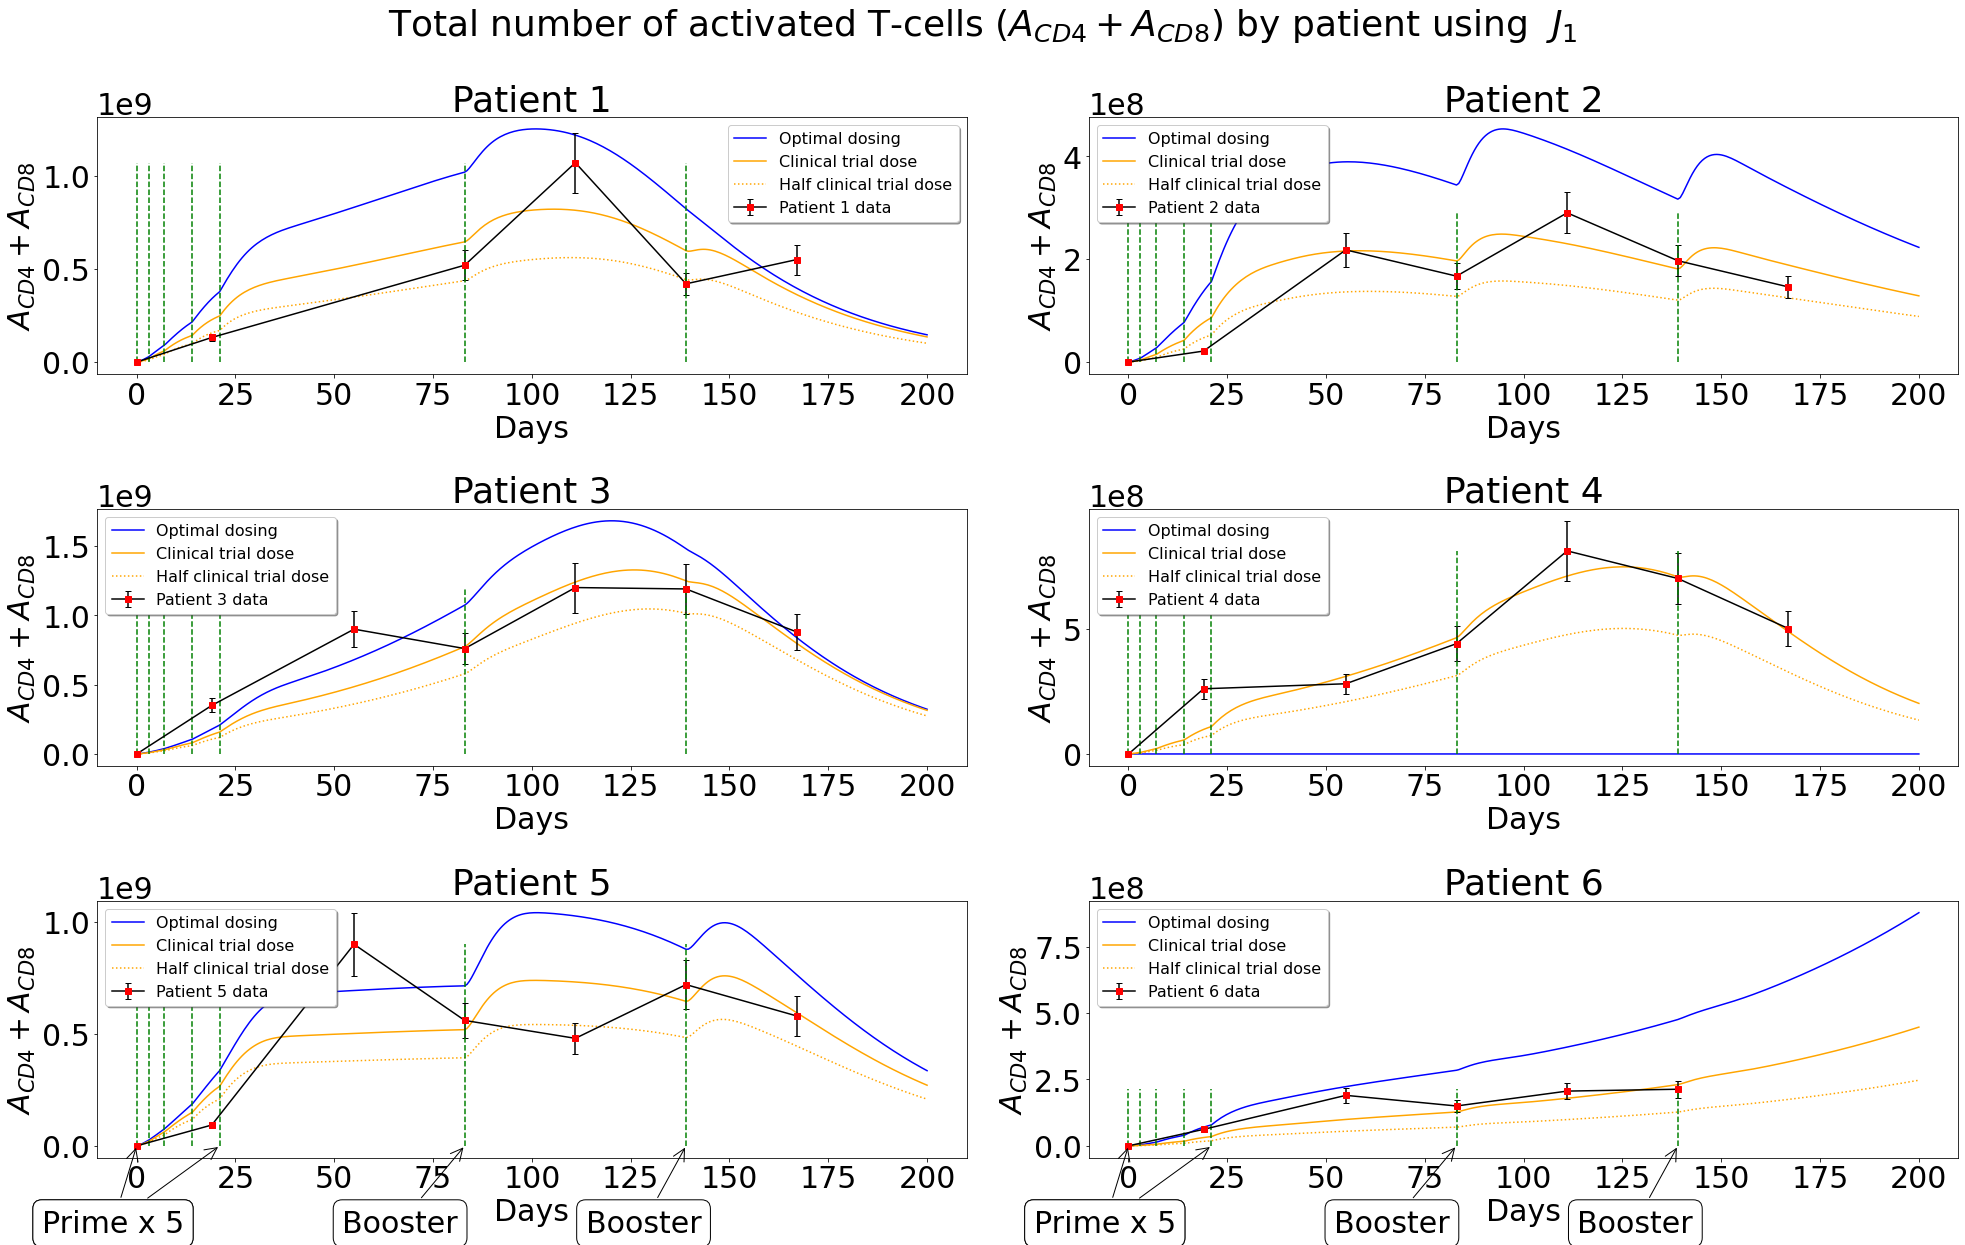

In [60]:
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 30,})
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_1$')
for i in range(len(axs.flat)):
    l = len(patients_oc[i+1][1]) 
    t = patients_oc[i+1][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = patients_oc[i+1][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[i+1][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[i+1][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
    else:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()

## Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_2$

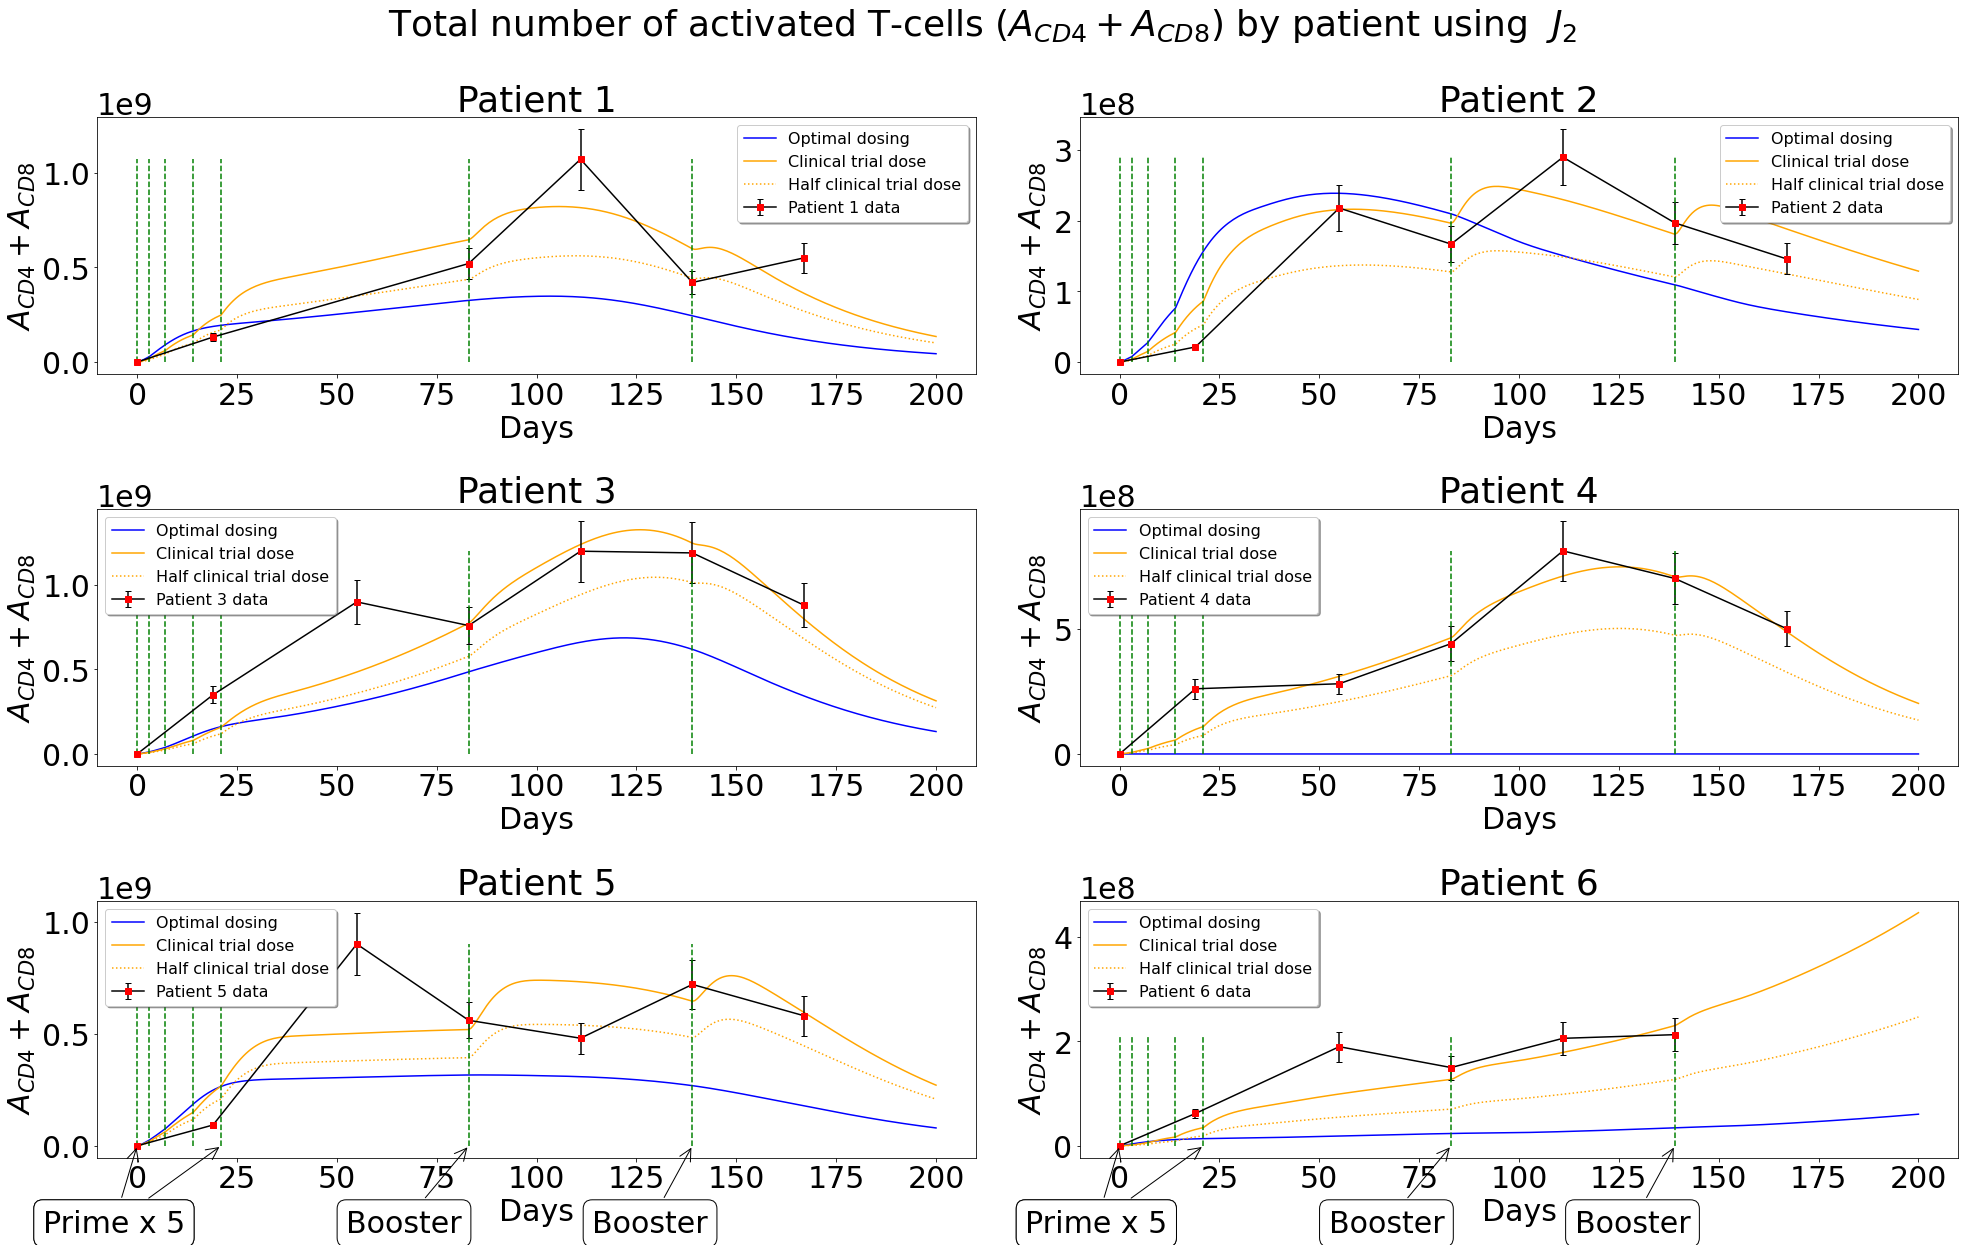

In [61]:
#%% lower bound of peptides close to 0 or 1/2-fold baseline
def y(x):
    if x == 0:
        y = j2patients_oc # 0
    if x == 1:
        y = j2patients_oc1 #1/2
    return y
#%% Choose which patient optimization to plot
opt_patients = y(0) 
# x=0 plots when the lower bound of peptide is 0, this is the case presented in the paper. x=1 is the case in the Suplemental

'Total number of activated T-cells (ACD4+ + ACD8) by patient using J_2'
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 30,})
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_2$')
for i in range(len(axs.flat)):
    l = len(opt_patients[i+1][1]) 
    t = opt_patients[i+1][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[i+1][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = j0patients_max[i+1][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = j0patients_half[i+1][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
    else:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()

#  Diameter of Tumor by patient

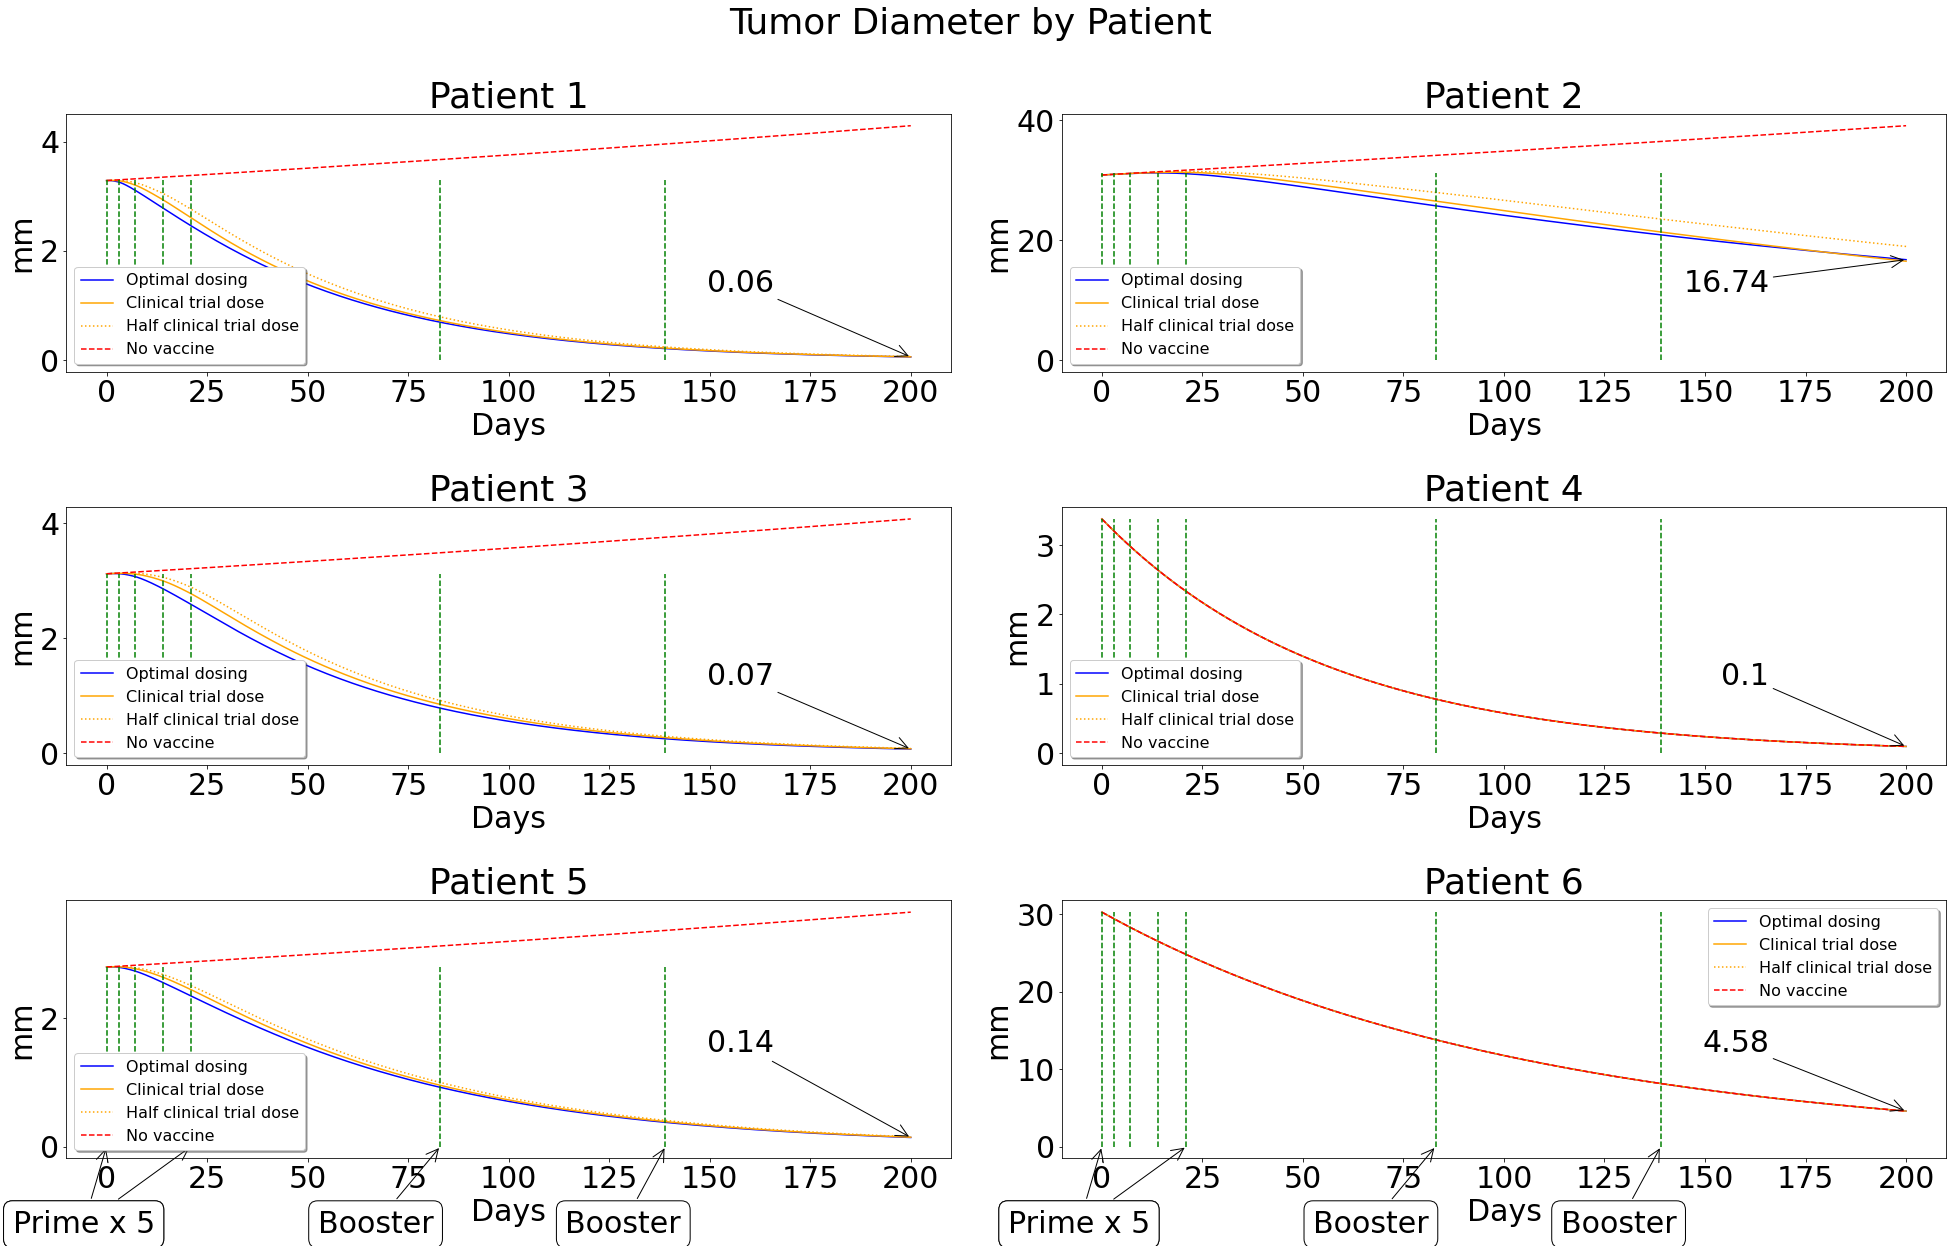

In [62]:
'Tumor Cells to Tumor Diameter'
def diam(cells):
    diam = 2*(((cells*3)/(4*(np.pi)*0.7405*1e5))**(1/3))
    return diam

'Diameter of Tumor by patient'
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 30,})
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Tumor Diameter by Patient')
for i in range(len(axs.flat)):
    l = len (opt_patients[i+1][1]) 
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[i+1][1][l-5:l]
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[i+1][1][l-5:l]
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[i+1][1][l-5:l]
    [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = patients_none[i+1][1][l-5:l]
    
    Tdiam = np.zeros(len(T))
    Tcdiam = np.zeros(len(Tc))
    Thdiam = np.zeros(len(Th))
    Tndiam = np.zeros(len(Tn))
    
    for j in range(len(t)):
        Tdiam[j] = diam(T[j])
        Tcdiam[j] = diam(Tc[j])
        Thdiam[j] = diam(Th[j])
        Tndiam[j] = diam(Tn[j])
    
    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Tdiam, color = 'blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'orange', label = 'Half clinical trial dose')
        axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].set_ylabel('mm')
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
        axs.flat[i].legend(loc='lower left', fancybox=True, shadow=True,fontsize = 16)
        b = str((round(Tdiam[len(t)-1],2)))
        fT = Tdiam[len(t)-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.4), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        
    else:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Tdiam, color = 'blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'orange', label = 'Half clinical trial dose')
        axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].set_ylabel('mm')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
        b = str((round(Tdiam[len(t)-1],2)))
        fT = Tdiam[len(t)-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.5), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()

## Optimal Peptide and Adjuvant Concentrations

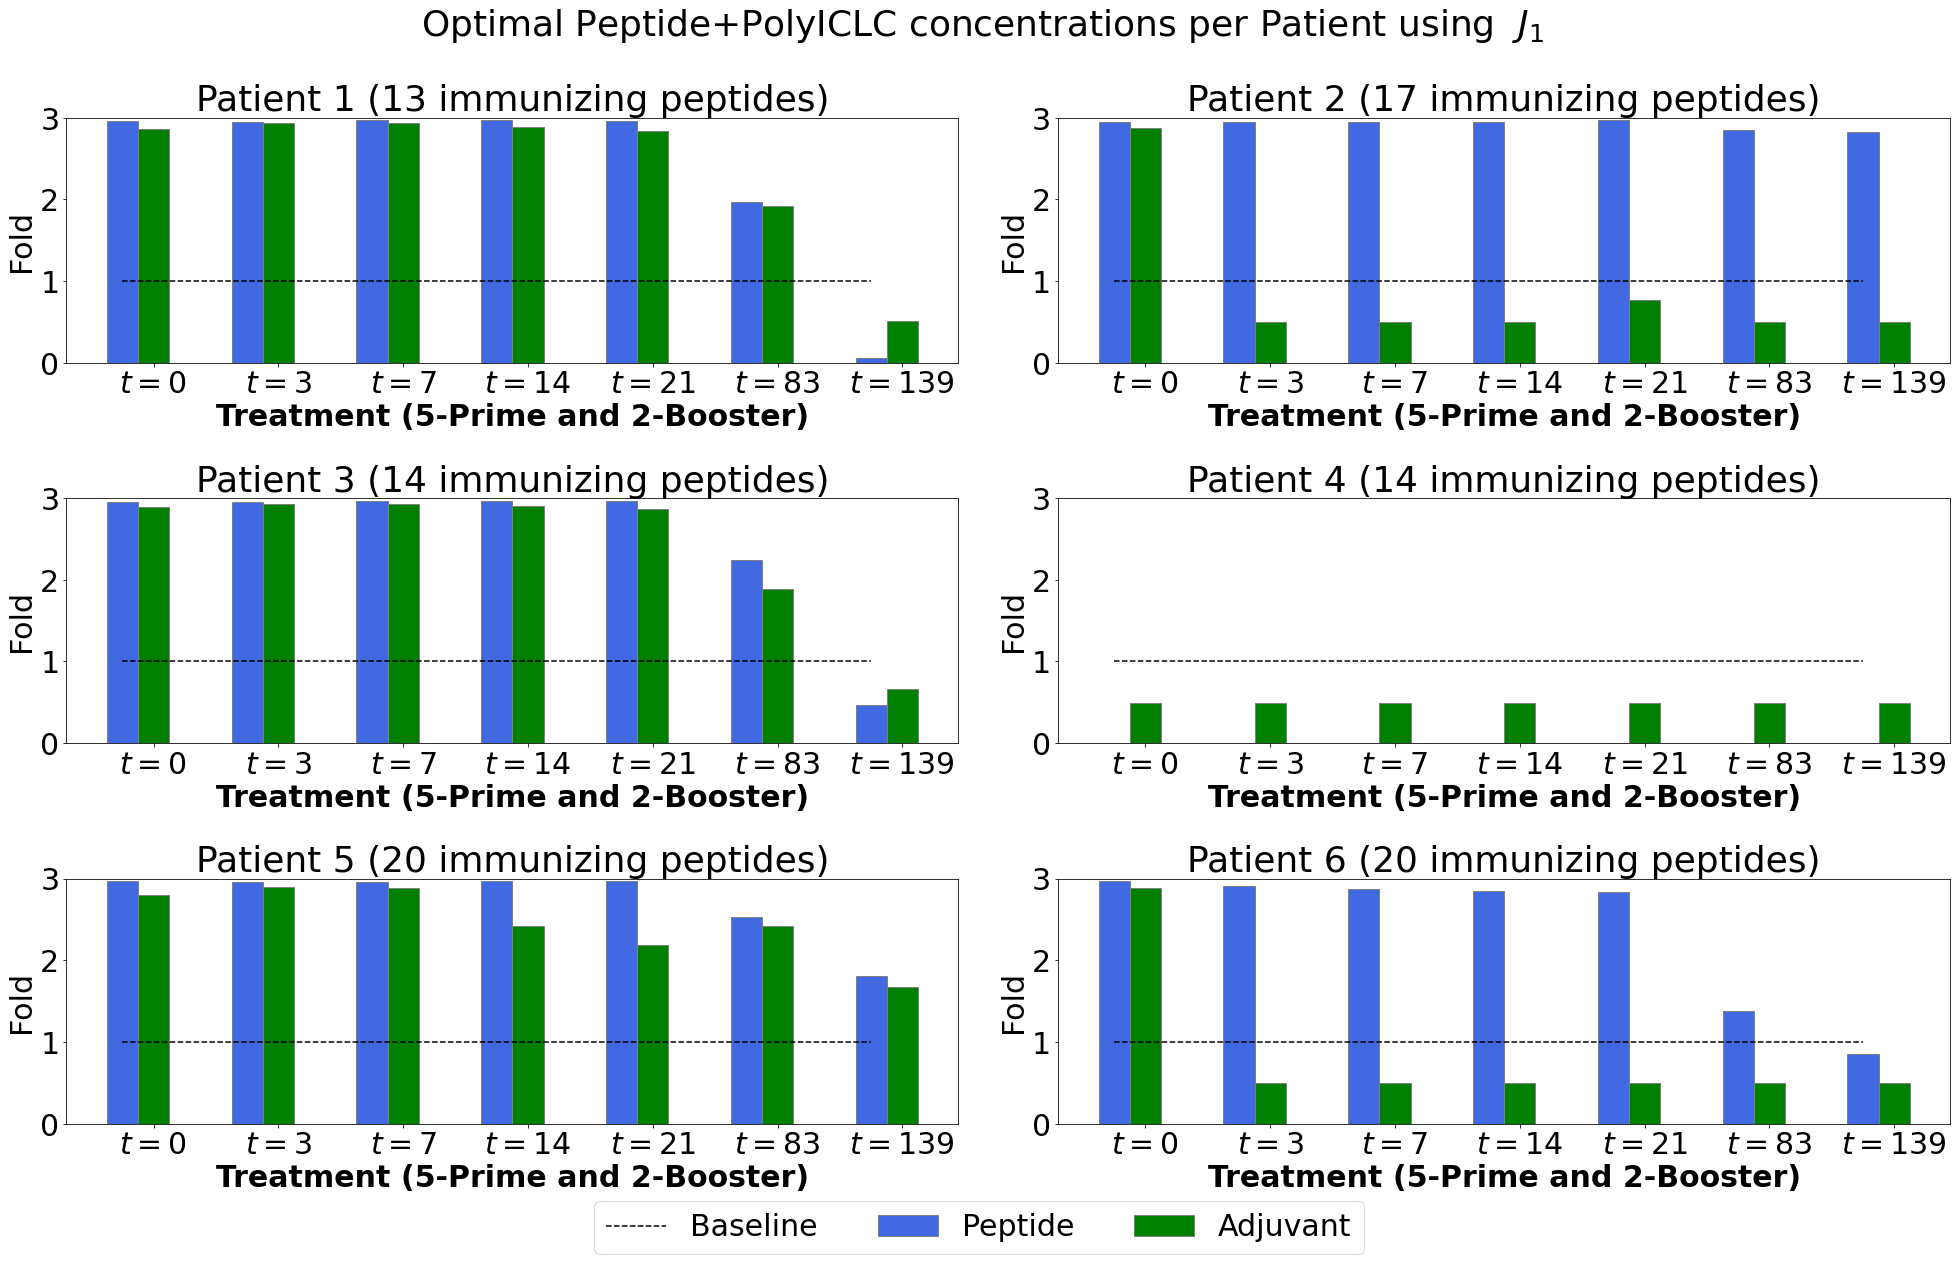

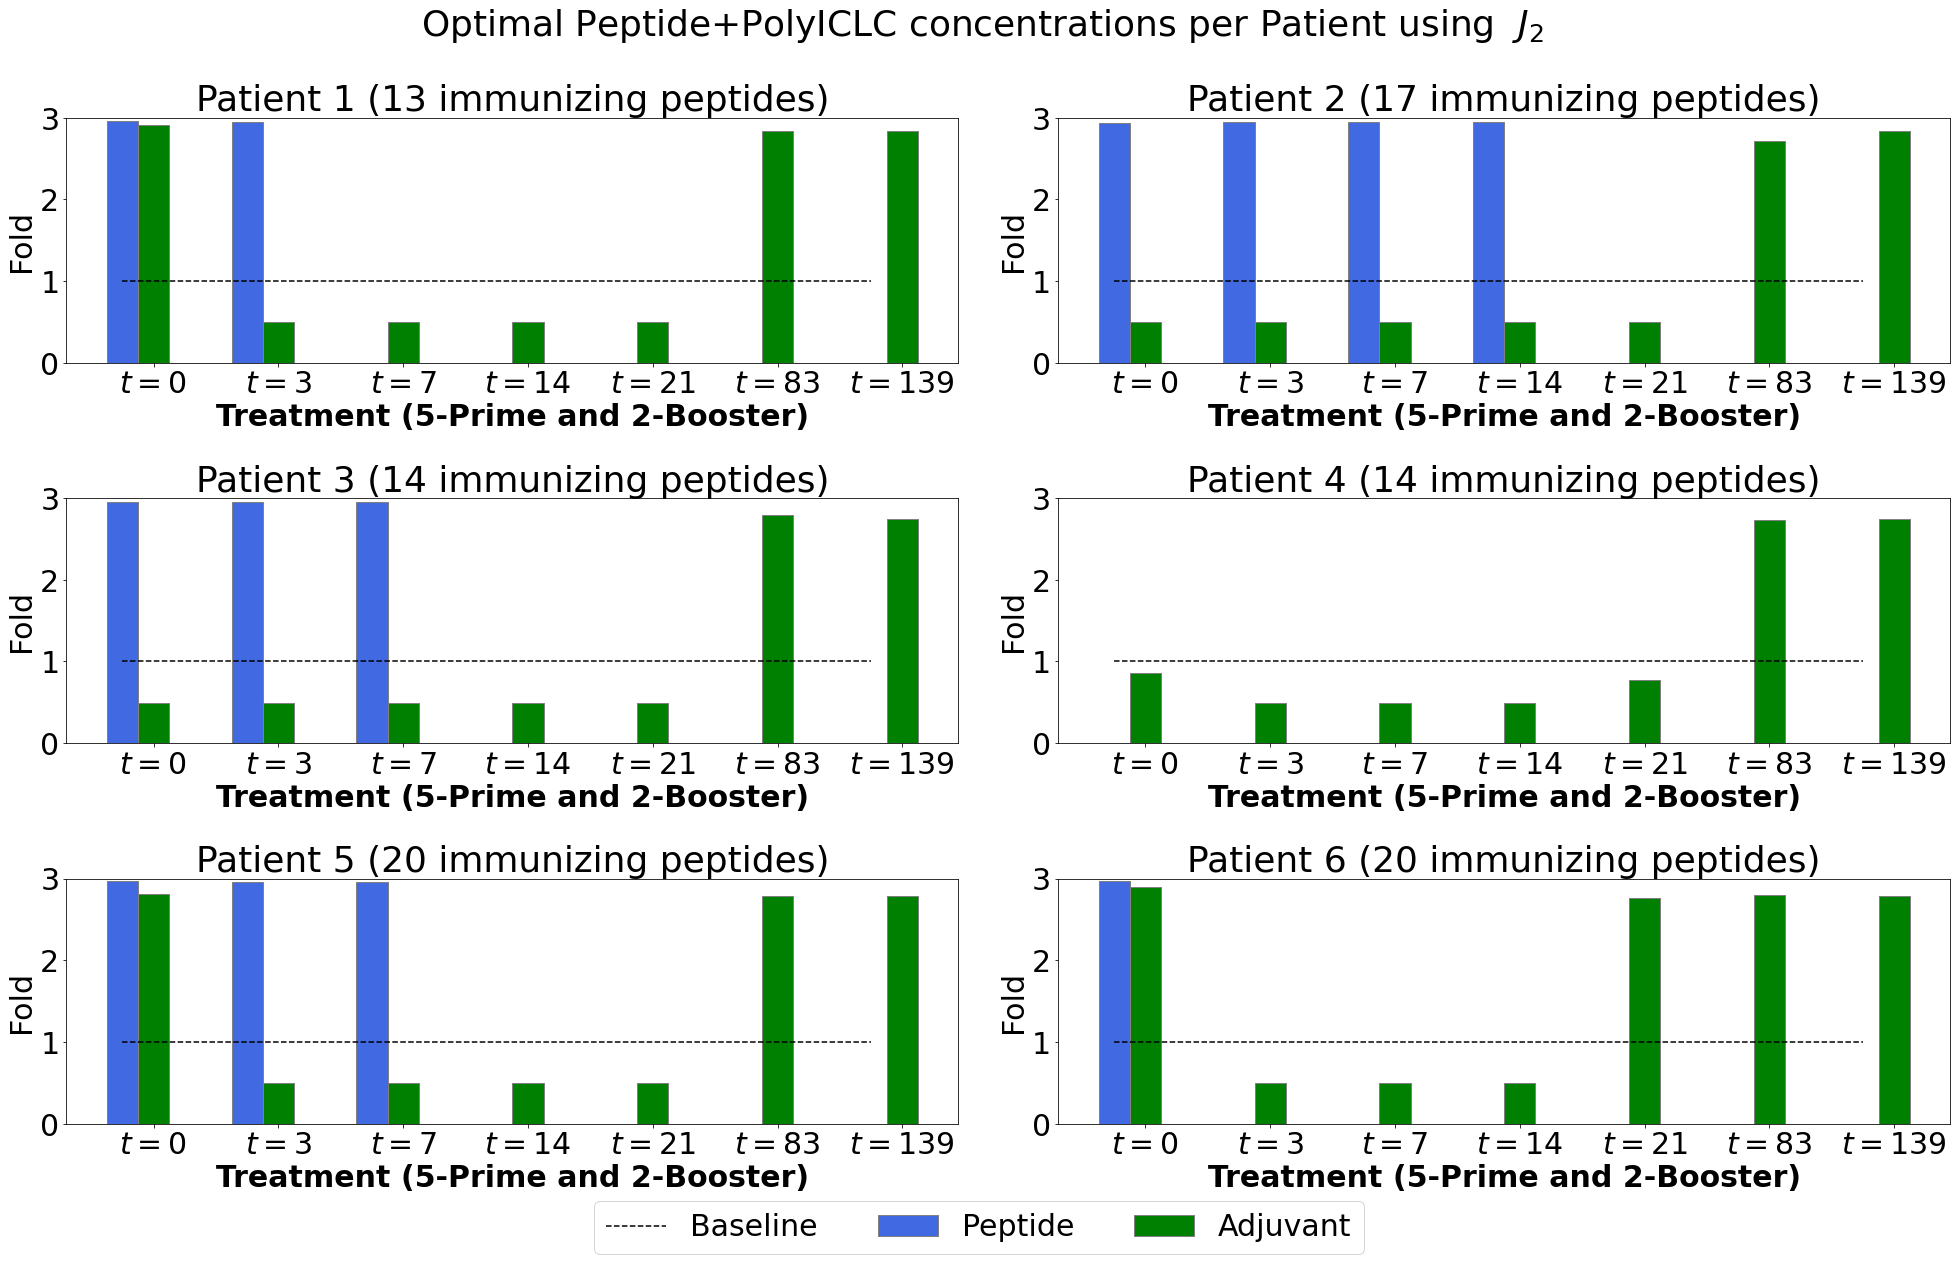

In [63]:
vac_time = 0.001 #Injection rate (20 secs per injection)
rho = 1/vac_time
'Conversion functions from pmol to mg'
def masstomolar(mass,mw):
    'pmol = microgram / molecular weight (KD) '
    molar = (1e6*mass)/mw #'mass -> grams'
    return molar
def molartomass(molar,mw):
    'gram = pmol * molecular weight (KD) /10^6'
    mass = round((molar *mw)/1e6,1)  #'molar -> picomole pmol'
    return mass
#opt_patients = y(0)
max_dose = [3.9,5.1,4.2,4.2,6,6]

'Peptide dose in mg by patient'
peptides = [13,17,14,14,20,20] # number of immunogenic peptides by patient
peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66] # peptides molecular weight
peptide_dose_j1 = np.zeros((6,len(t)))
peptide_dose_j2 = np.zeros((6,len(t)))
peptide_dosec = np.zeros((6,len(t)))
for i in range(6):
    [t_j1,state_j1,adjoint_j1,control_hp_j1, control_ha_j1,rtime_j1] = patients_oc[i+1]
    [t_j2,state_j2,adjoint_j2,control_hp_j2, control_ha_j2,rtime_j2] = opt_patients[i+1]
    [t,statec,control_hpc, control_hac,rtimec] = patients_max[i+1]
    for j in range(len(t)):
        peptide_dose_j1[i][j] = molartomass(control_hp_j1[j],peptide_mw[i])
        peptide_dose_j2[i][j] = molartomass(control_hp_j2[j],peptide_mw[i])
        peptide_dosec[i][j] = molartomass(control_hpc[j],peptide_mw[i])
        
adjuvant_dose_j1 = np.zeros([6,len(t)])
adjuvant_dose_j2 = np.zeros([6,len(t)])
adjuvant_dosec = np.zeros([6,len(t)])
for i in range(6):
    adjuvant_dose_j1[i] = patients_oc[i+1][4]
    adjuvant_dose_j2[i] = opt_patients[i+1][4]
    adjuvant_dosec[i] = patients_max[i+1][4]
    
peptide_doses_j1 = np.zeros([6,len(tau)])
adjuvant_doses_j1 = np.zeros([6,len(tau)])    
peptide_doses_j2 = np.zeros([6,len(tau)])
adjuvant_doses_j2 = np.zeros([6,len(tau)])
peptide_dosesc = np.zeros([6,len(tau)])
adjuvant_dosesc = np.zeros([6,len(tau)])

for j in range(6):
    for i in range(len(tau)):
        peptide_doses_j1[j][i] = integrate.trapezoid(rho*peptide_dose_j1[j][2*i*100:((2*i+1)*100)-1],
                                                  t_j1[2*i*100:((2*i+1)*100)-1])
        adjuvant_doses_j1[j][i] = integrate.trapezoid((rho*adjuvant_dose_j1[j][2*i*100:((2*i+1)*100)-1])/1000,
                                                  t_j1[2*i*100:((2*i+1)*100)-1])
        peptide_doses_j2[j][i] = integrate.trapezoid(rho*peptide_dose_j2[j][2*i*100:((2*i+1)*100)-1],
                                                  t_j2[2*i*100:((2*i+1)*100)-1])
        adjuvant_doses_j2[j][i] = integrate.trapezoid((rho*adjuvant_dose_j2[j][2*i*100:((2*i+1)*100)-1])/1000,
                                                  t_j2[2*i*100:((2*i+1)*100)-1])
        peptide_dosesc[j][i] = integrate.trapezoid(rho*peptide_dosec[j][2*i*100:((2*i+1)*100)-1],
                                                  t[2*i*100:((2*i+1)*100)-1])
        adjuvant_dosesc[j][i] = integrate.trapezoid((rho*adjuvant_dosec[j][2*i*100:((2*i+1)*100)-1])/1000,
                                                  t[2*i*100:((2*i+1)*100)-1])
        
barWidth = 0.25
max_dose = [3.9,5.1,4.2,4.2,6,6]
plt.rcParams.update({'font.size': 30,})

fig, axs = plt.subplots(3, 2,figsize=(28,18))
plt.suptitle('Optimal Peptide+PolyICLC concentrations per Patient using  $J_1$')
# Set position of bar on X axis
br1 = np.arange(len(tau))
br2 = [x + barWidth for x in br1]
for i in range(len(axs.flat)):
    axs.flat[i].set_title('Patient '+str(i+1)+' ('+str(peptides[i])+' immunizing peptides)')
    axs.flat[i].bar(br1, peptide_doses_j1[i]/max_dose[i] , color ='royalblue', width = barWidth,
            edgecolor ='grey', label ='Peptide')
    axs.flat[i].hlines(y = 1, xmin= 0, xmax = 6, 
                       colors= 'k',linestyle = '--')
    axs.flat[i].bar(br2, adjuvant_doses_j1[i]/2 , color ='g', width = barWidth,
            edgecolor ='grey', label ='Adjuvant')
    axs.flat[i].set_ylim(0,3)
    axs.flat[i].set_xlabel('Treatment (5-Prime and 2-Booster)', fontweight ='bold')
    axs.flat[i].set_ylabel('Fold')
    axs.flat[i].set_xticks([r + barWidth for r in range(len(tau))],
        ['$t=0$ ', '$t=3$', '$t=7$','$t=14$',
         '$t=21$', '$t=83$', '$t=139$' ])
labels = ['Baseline','Peptide','Adjuvant']
fig.legend(labels,loc='lower center',ncol=3) 
fig.tight_layout(rect=(0, .04, 1, 1))

fig, axs = plt.subplots(3, 2,figsize=(28,18))
plt.suptitle('Optimal Peptide+PolyICLC concentrations per Patient using  $J_2$')
# Set position of bar on X axis
br1 = np.arange(len(tau))
br2 = [x + barWidth for x in br1]
for i in range(len(axs.flat)):
    axs.flat[i].set_title('Patient '+str(i+1)+' ('+str(peptides[i])+' immunizing peptides)')
    axs.flat[i].bar(br1, peptide_doses_j2[i]/max_dose[i] , color ='royalblue', width = barWidth,
            edgecolor ='grey', label ='Peptide')
    axs.flat[i].hlines(y = 1, xmin= 0, xmax = 6, 
                       colors= 'k',linestyle = '--')
    axs.flat[i].bar(br2, adjuvant_doses_j2[i]/2 , color ='g', width = barWidth,
            edgecolor ='grey', label ='Adjuvant')
    axs.flat[i].set_ylim(0,3)
    axs.flat[i].set_xlabel('Treatment (5-Prime and 2-Booster)', fontweight ='bold')
    axs.flat[i].set_ylabel('Fold')
    axs.flat[i].set_xticks([r + barWidth for r in range(len(tau))],
        ['$t=0$ ', '$t=3$', '$t=7$','$t=14$',
         '$t=21$', '$t=83$', '$t=139$' ])
labels = ['Baseline','Peptide','Adjuvant'] 
fig.legend(labels,loc='lower center',ncol=3) 
fig.tight_layout(rect=(0, .04, 1, 1))

## Vaccine Dose-Response Curves

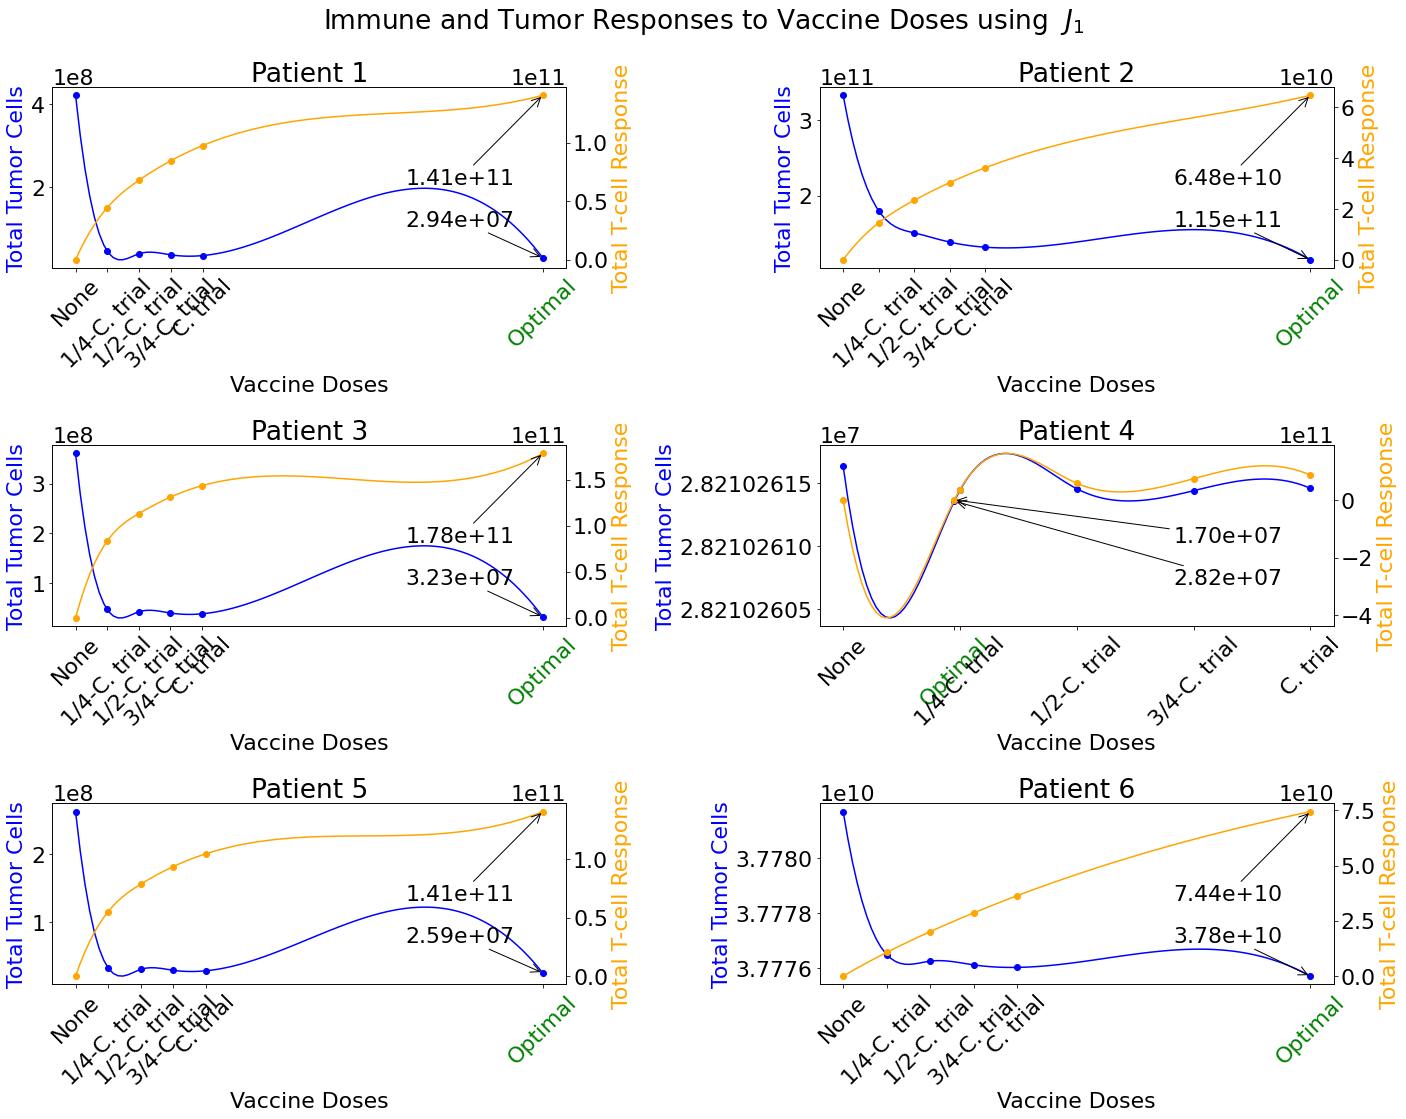

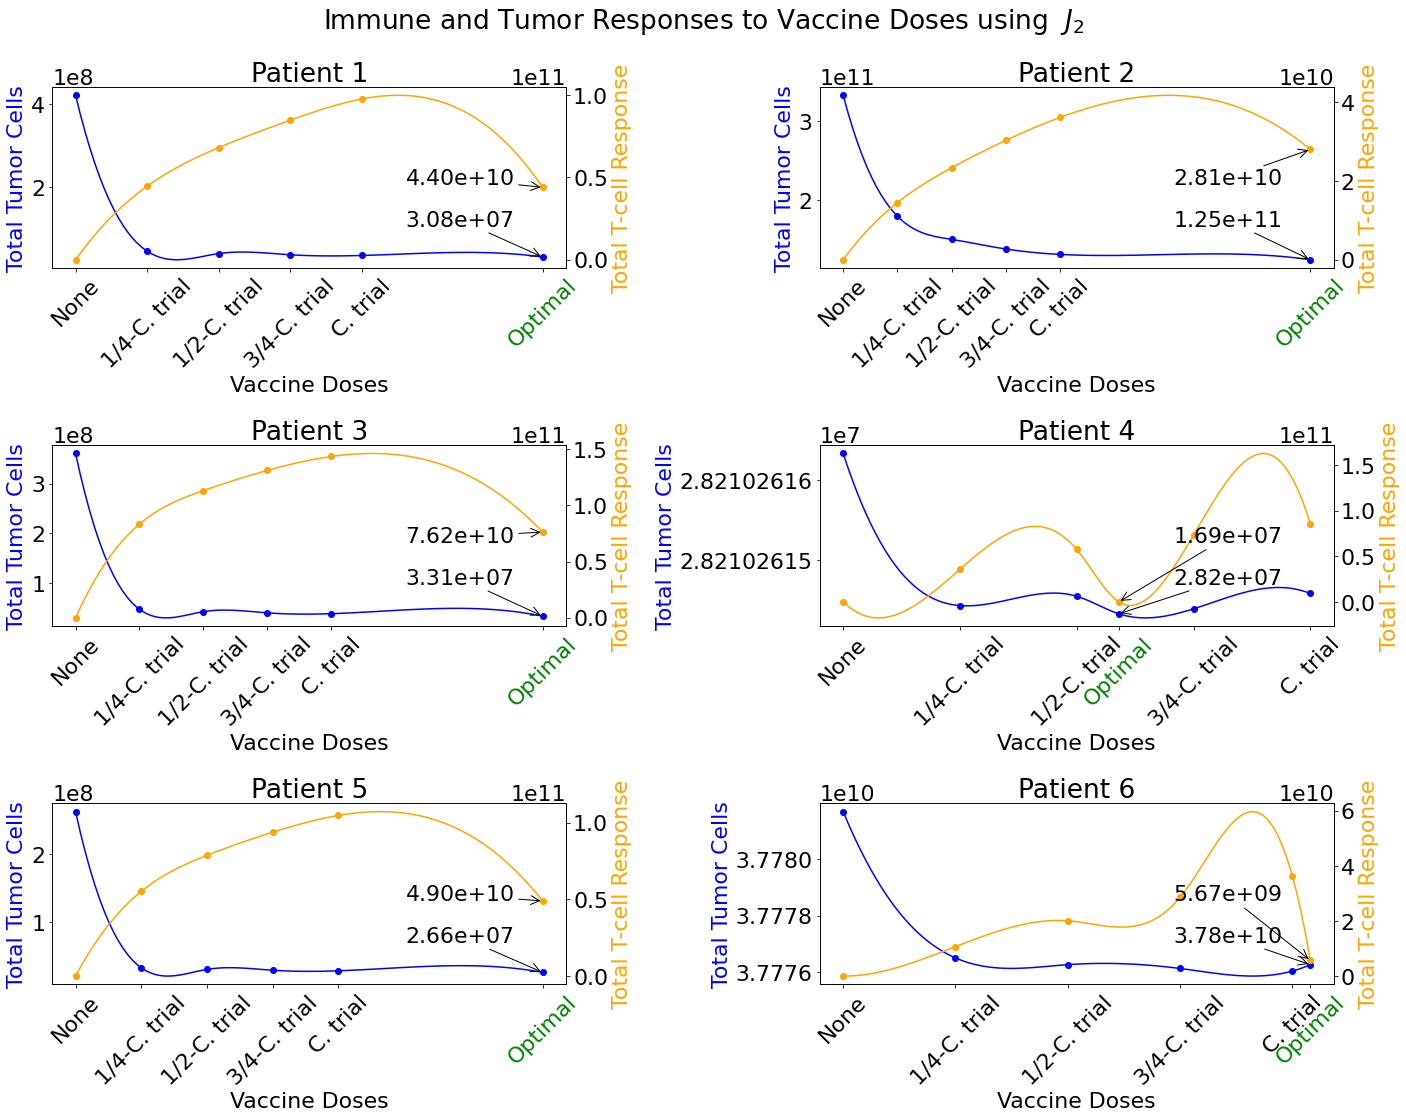

In [64]:
#opt_patients = y(0)
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 22,"axes.formatter.useoffset":False})

fig, axs = plt.subplots(3, 2,figsize=(20,16))
fig.suptitle('Immune and Tumor Responses to Vaccine Doses using  $J_1$')
for i in range(len(axs.flat)):
    patient = i+1
    ax = axs.flat[i]
    l = len(opt_patients[patient][1]) 
    t = opt_patients[patient][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = patients_oc[patient][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[patient][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Tq3, N_CD4q3, N_CD8q3, A_CD4q3, A_CD8q3] = patients_3quarter[patient][1][l-5:l]
    Total_cellsq3 = A_CD4q3 + A_CD8q3
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[patient][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    [Tq, N_CD4q, N_CD8q, A_CD4q, A_CD8q] = patients_quarter[patient][1][l-5:l]
    Total_cellsq = A_CD4q + A_CD8q
    [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = patients_none[patient][1][l-5:l] 
    Total_cellsn = A_CD4n + A_CD8n
    
    Total_tumors = np.array([integrate.trapezoid(T,t),
                             integrate.trapezoid(Tc,t),
                             integrate.trapezoid(Tq3,t),
                             integrate.trapezoid(Th,t),
                             integrate.trapezoid(Tq,t),
                             integrate.trapezoid(Tn,t)])
    Total_Tcells = np.array([integrate.trapezoid(Total_cells,t),
                             integrate.trapezoid(Total_cellsc,t),
                             integrate.trapezoid(Total_cellsq3,t),
                             integrate.trapezoid(Total_cellsh,t),
                             integrate.trapezoid(Total_cellsq,t),
                             integrate.trapezoid(Total_cellsn,t)])
    Total_vaccine = sum(peptide_doses_j1[patient-1])+sum(adjuvant_doses_j1[patient-1])        
    Total_vaccinec = sum(peptide_dosesc[patient-1])+sum(adjuvant_dosesc[patient-1])        
    Total_vaccineq3 = 3*Total_vaccinec/4
    Total_vaccineh = Total_vaccinec/2
    Total_vaccineq = Total_vaccinec/4
    Vaccine_dose = np.array([Total_vaccine,Total_vaccinec, Total_vaccineq3,
                             Total_vaccineh,Total_vaccineq,0])/max(Total_vaccine,Total_vaccinec)
    vspan = np.linspace(min(Vaccine_dose),max(Vaccine_dose),100)
    Tumor_response = interp1d(Vaccine_dose, Total_tumors, kind='cubic', fill_value='extrapolate') 
    Tcell_response = interp1d(Vaccine_dose, Total_Tcells, kind='cubic', fill_value='extrapolate') 
    ax.set_title('Patient '+ str(patient))
    ax.plot(Vaccine_dose, Total_tumors,'o',color = 'blue')
    ax.plot(vspan, Tumor_response(vspan),color = 'blue', label = 'Tumor Response')
    ax.set_ylabel('Total Tumor Cells',color = 'blue')
    ax.set_xticks(ticks=Vaccine_dose)
    ax.set_xticklabels(labels=['Optimal','C. trial','3/4-C. trial','1/2-C. trial',
                               '1/4-C. trial','None'],rotation = 45)
    ax.get_xticklabels()[0].set_color("green")
    ax.set_xlabel('Vaccine Doses')
    b = str('{:.2e}'.format(round(Total_tumors[0],0)))
    fT = Total_tumors[0]
    ax.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.32), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    ax2= ax.twinx()
    ax2.plot(Vaccine_dose, Total_Tcells,'o' ,color = 'orange')
    ax2.plot(vspan, Tcell_response(vspan), color = 'orange', label = 'T-cell Response')
    ax2.set_ylabel('Total T-cell Response',color = 'orange')
    ax2.set_xlabel('Drug Concentration')
    b = str('{:.2e}'.format(round(Total_Tcells[0],0)))
    fT = Total_Tcells[0]
    ax2.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.55), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    
    #ax2.legend(loc='best', fancybox=True, shadow=True,fontsize = 14)
    fig.tight_layout()
    
fig, axs = plt.subplots(3, 2,figsize=(20,16))
fig.suptitle('Immune and Tumor Responses to Vaccine Doses using  $J_2$')
for i in range(len(axs.flat)):
    patient = i+1
    ax = axs.flat[i]
    l = len(opt_patients[patient][1]) 
    t = opt_patients[patient][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[patient][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[patient][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Tq3, N_CD4q3, N_CD8q3, A_CD4q3, A_CD8q3] = patients_3quarter[patient][1][l-5:l]
    Total_cellsq3 = A_CD4q3 + A_CD8q3
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[patient][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    [Tq, N_CD4q, N_CD8q, A_CD4q, A_CD8q] = patients_quarter[patient][1][l-5:l]
    Total_cellsq = A_CD4q + A_CD8q
    [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = patients_none[patient][1][l-5:l] 
    Total_cellsn = A_CD4n + A_CD8n
    
    Total_tumors = np.array([integrate.trapezoid(T,t),
                             integrate.trapezoid(Tc,t),
                             integrate.trapezoid(Tq3,t),
                             integrate.trapezoid(Th,t),
                             integrate.trapezoid(Tq,t),
                             integrate.trapezoid(Tn,t)])
    Total_Tcells = np.array([integrate.trapezoid(Total_cells,t),
                             integrate.trapezoid(Total_cellsc,t),
                             integrate.trapezoid(Total_cellsq3,t),
                             integrate.trapezoid(Total_cellsh,t),
                             integrate.trapezoid(Total_cellsq,t),
                             integrate.trapezoid(Total_cellsn,t)])
    Total_vaccine = sum(peptide_doses_j2[patient-1])+sum(adjuvant_doses_j2[patient-1])        
    Total_vaccinec = sum(peptide_dosesc[patient-1])+sum(adjuvant_dosesc[patient-1])        
    Total_vaccineq3 = 3*Total_vaccinec/4
    Total_vaccineh = Total_vaccinec/2
    Total_vaccineq = Total_vaccinec/4
    Vaccine_dose = np.array([Total_vaccine,Total_vaccinec, Total_vaccineq3,
                             Total_vaccineh,Total_vaccineq,0])/max(Total_vaccine,Total_vaccinec)
    vspan = np.linspace(min(Vaccine_dose),max(Vaccine_dose),100)
    Tumor_response = interp1d(Vaccine_dose, Total_tumors, kind='cubic', fill_value='extrapolate') 
    Tcell_response = interp1d(Vaccine_dose, Total_Tcells, kind='cubic', fill_value='extrapolate') 
    ax.set_title('Patient '+ str(patient))
    ax.plot(Vaccine_dose, Total_tumors,'o',color = 'blue')
    ax.plot(vspan, Tumor_response(vspan),color = 'blue', label = 'Tumor Response')
    ax.set_ylabel('Total Tumor Cells',color = 'blue')
    ax.set_xticks(ticks=Vaccine_dose)
    ax.set_xticklabels(labels=['Optimal','C. trial','3/4-C. trial','1/2-C. trial',
                               '1/4-C. trial','None'],rotation = 45)
    ax.get_xticklabels()[0].set_color("green")
    ax.set_xlabel('Vaccine Doses')
    b = str('{:.2e}'.format(round(Total_tumors[0],0)))
    fT = Total_tumors[0]
    ax.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.32), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    ax2= ax.twinx()
    ax2.plot(Vaccine_dose, Total_Tcells,'o' ,color = 'orange')
    ax2.plot(vspan, Tcell_response(vspan), color = 'orange', label = 'T-cell Response')
    ax2.set_ylabel('Total T-cell Response',color = 'orange')
    ax2.set_xlabel('Drug Concentration')
    b = str('{:.2e}'.format(round(Total_Tcells[0],0)))
    fT = Total_Tcells[0]
    ax2.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.55), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    
    #ax2.legend(loc='best', fancybox=True, shadow=True,fontsize = 14)
    fig.tight_layout()
    